In [1]:
# from dataset import *
from dataset.raw_data import air_quality_test_data, air_quality_train_data
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

/home/hoang/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hoang/.local/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/hoang/.local/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
raw = air_quality_train_data("../data/data-train")
raw["input"].keys()

dict_keys(['S0000370-Ba Trieu', 'S0000229-Quan Hoa', 'S0000310-Hang Trong', 'S0000210-Truong THCS Yen So', 'S0000153-Truong Tieu hoc Tran Quoc Toan', 'S0000137-Ngoc Khanh', 'S0000541-Tran Quang Khai', 'S0000238-He thong lien cap Lomonoxop - Mam non', 'S0000143-Thu vien - DHQG Ha Noi', 'S0000171-GENESIS School', 'S0000264-FDS - Ton That Thuyet'])

# Missing Data Statistic

In [3]:
def missing_data_statistic(data):
    out = {}

    for name, station in data.items():
        ms = {}
        for col in ("PM2.5", "temperature", "humidity"):
            ms[col] = station["data"][col].isna().sum() / len(station["data"])

        out[name] = ms

    return pd.DataFrame.from_dict(out)

missing_data_statistic(raw["input"])

,S0000370-Ba Trieu,S0000229-Quan Hoa,S0000310-Hang Trong,S0000210-Truong THCS Yen So,S0000153-Truong Tieu hoc Tran Quoc Toan,S0000137-Ngoc Khanh,S0000541-Tran Quang Khai,S0000238-He thong lien cap Lomonoxop - Mam non,S0000143-Thu vien - DHQG Ha Noi,S0000171-GENESIS School,S0000264-FDS - Ton That Thuyet
PM2.5,0.215222,0.053222,0.065667,0.052778,0.109333,0.099667,0.243000,0.065444,0.272333,0.369556,0.240333
temperature,0.214333,0.053333,0.070333,0.052444,0.109444,0.075667,0.249889,0.027556,0.276889,0.369444,0.240556
humidity,0.214333,0.053333,0.070333,0.052444,0.109444,0.075667,0.278000,0.027444,0.276889,0.369444,0.240667


# Prediocity

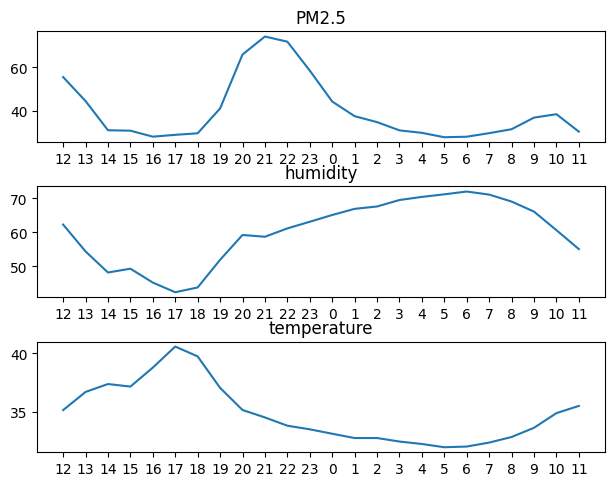

In [19]:
def plot_continuity(df: pd.DataFrame, idx: int, seq_len: int = 24):
    from datetime import datetime
    start = idx * seq_len
    end = start + seq_len
    
    fig, axes = plt.subplots(nrows=3)
    plt.tight_layout()

    timeline = df["timestamp"][start : end]
    timeline = timeline.map(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M").hour).tolist()
    for i, col in enumerate(("PM2.5", "humidity", "temperature")):
        axes[i].plot(df[col][start : end].tolist())
        axes[i].set_title(col)
        axes[i].set_xticks(range(len(timeline)))
        axes[i].set_xticklabels(timeline)

plot_continuity(raw["input"]["S0000229-Quan Hoa"]["data"], 9)

# Correlation between PM2.5 and temperature

In [5]:
def correlation_table(data):
    from datetime import datetime
    from utils.functional import get_solar_term

    temp_corr = {}
    humd_corr = {}

    for st_name in data.keys():
        station = data[st_name]["data"].copy()

        if isinstance(station, pd.DataFrame):
            date = station["timestamp"].map(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M"))
            station["month"] = date.map(lambda x: x.month)
            g_station = [group for _, group in station.groupby(['month'])]

            for i in range(12):
                station_im = g_station[i]
                station_im.drop(["Unnamed: 0", "timestamp"], axis=1, inplace=True)

                corr = station_im.corr()["PM2.5"]
                if st_name not in temp_corr:
                    temp_corr[st_name] = [corr["temperature"]]
                    humd_corr[st_name] = [corr["humidity"]]
                else:
                    temp_corr[st_name].append(corr["temperature"])
                    humd_corr[st_name].append(corr["humidity"])
            
            # station["season"] = date.map(lambda x: x.month // 4)
            # station["solar_term"] = date.map(lambda x: get_solar_term(x))
            # corr[st_name] = station.corr()["PM2.5"]

    return pd.DataFrame(temp_corr), pd.DataFrame(humd_corr)

temp_corr, humd_corr = correlation_table(raw["input"])

In [6]:
temp_corr

,S0000370-Ba Trieu,S0000229-Quan Hoa,S0000310-Hang Trong,S0000210-Truong THCS Yen So,S0000153-Truong Tieu hoc Tran Quoc Toan,S0000137-Ngoc Khanh,S0000541-Tran Quang Khai,S0000238-He thong lien cap Lomonoxop - Mam non,S0000143-Thu vien - DHQG Ha Noi,S0000171-GENESIS School,S0000264-FDS - Ton That Thuyet
0,0.339210,0.371092,0.178021,0.287358,0.357712,0.392966,0.265922,0.270385,-0.046290,NaN,0.342711
1,NaN,-0.118379,-0.159979,-0.234800,-0.075097,-0.055005,-0.090580,-0.087527,-0.109471,NaN,NaN
2,NaN,-0.041706,-0.155220,-0.175775,-0.096512,-0.256401,0.043204,-0.045481,-0.113560,NaN,NaN
3,-0.291307,-0.309299,-0.416218,-0.339026,-0.396157,-0.306108,-0.299126,-0.245402,-0.248680,-0.361760,-0.225109
4,-0.116163,-0.088055,-0.219533,-0.226633,-0.226278,-0.217707,-0.209403,-0.060428,-0.246187,-0.046621,-0.216936
5,-0.013279,-0.132548,-0.036510,-0.110642,-0.148281,-0.111926,-0.198521,-0.164414,-0.216795,-0.167346,-0.172027
6,-0.272339,-0.262636,-0.301037,-0.247498,-0.348996,-0.267103,-0.317723,-0.257412,-0.243230,-0.264354,-0.237474
7,0.087641,0.017706,0.080909,0.078909,0.062912,0.107850,-0.119026,-0.103261,-0.043264,0.009122,-0.017336
8,0.167275,0.160469,0.177287,0.172821,0.055920,0.158099,0.099685,0.040074,0.214485,0.233892,0.086425
9,-0.085654,-0.170252,-0.102136,-0.120908,-0.140333,-0.057343,-0.157126,-0.337234,-0.224069,-0.125586,-0.222311


In [7]:
humd_corr

,S0000370-Ba Trieu,S0000229-Quan Hoa,S0000310-Hang Trong,S0000210-Truong THCS Yen So,S0000153-Truong Tieu hoc Tran Quoc Toan,S0000137-Ngoc Khanh,S0000541-Tran Quang Khai,S0000238-He thong lien cap Lomonoxop - Mam non,S0000143-Thu vien - DHQG Ha Noi,S0000171-GENESIS School,S0000264-FDS - Ton That Thuyet
0,0.558847,0.519442,0.410140,0.560832,0.531429,0.403867,0.556331,0.604532,0.239125,NaN,0.533466
1,NaN,0.041228,0.259246,0.277113,0.154435,0.143109,0.182337,0.199819,0.252159,NaN,NaN
2,NaN,0.352505,0.413984,0.362467,0.340233,0.285731,0.633767,0.408393,0.359220,NaN,NaN
3,0.198852,0.239000,0.257827,0.306415,0.248594,0.209042,-0.042530,0.234739,0.198743,0.465133,0.163399
4,-0.037742,-0.000914,-0.033752,0.156999,-0.061559,-0.032608,-0.071621,-0.016276,-0.144012,0.330861,0.130190
5,0.210209,0.183134,0.099474,0.110405,0.249135,0.125141,0.229460,0.186284,0.106277,-0.019339,0.204224
6,0.263971,0.268001,0.298593,0.257859,0.348300,0.258139,0.306767,0.266611,0.239622,0.277060,0.229841
7,-0.023643,0.055940,0.036234,0.008380,0.042902,-0.032618,0.219111,0.156239,0.111726,0.046325,0.104051
8,-0.094510,-0.064550,-0.084552,-0.063398,0.054867,-0.062450,-0.003312,0.032067,-0.105391,-0.160012,0.000331
9,0.090863,0.129412,-0.001582,0.007530,0.145847,0.074421,0.131609,0.229028,0.191877,0.108203,0.133861


# PM2.5 Correlation among stations

In [8]:
def corr_among_stations(data):
    corr = {}
    for st_name in data:
        station = data[st_name]["data"]

        corr[st_name] = station["PM2.5"]

    return pd.DataFrame(corr).corr()

def plot_stations_corr(
    data,
    corr: pd.DataFrame,
    threshold: float = 0.75,
    size: tuple = (4, 3),
    figsize: tuple = (20, 10),
    dpi: int = 80
):
    nrows, ncols = size
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)
    fig.tight_layout()

    arr_corr = torch.from_numpy(corr.values)
    locs = torch.tensor([station["loc"] for station in data.values()])
    st_names = [name.split("-")[-1] for name in data.keys()]

    for i in range(arr_corr.size(0)):
        row_idx = i // ncols
        col_idx = i % ncols
        ax = axes[row_idx, col_idx]

        keep_ids = arr_corr[i] > threshold
        keep_locs = locs[keep_ids]
        ignore_locs = locs[~keep_ids]

        ax.plot(keep_locs[:, 0], keep_locs[:, 1], color="green", marker="*", ls="")
        ax.plot(ignore_locs[:, 0], ignore_locs[:, 1], color="gray", marker="*", ls="")

        for idx in range(locs.size(0)):
            ax.text(locs[idx, 0], locs[idx, 1], st_names[idx], fontsize=5)

        ax.plot(locs[i, 0], locs[i, 1], "ro")

    plt.show()    

corr = corr_among_stations(raw["input"])
corr

,S0000370-Ba Trieu,S0000229-Quan Hoa,S0000310-Hang Trong,S0000210-Truong THCS Yen So,S0000153-Truong Tieu hoc Tran Quoc Toan,S0000137-Ngoc Khanh,S0000541-Tran Quang Khai,S0000238-He thong lien cap Lomonoxop - Mam non,S0000143-Thu vien - DHQG Ha Noi,S0000171-GENESIS School,S0000264-FDS - Ton That Thuyet
S0000370-Ba Trieu,1.000000,0.725377,0.628010,0.573008,0.666517,0.718789,0.750525,0.659480,0.881434,0.633884,0.749678
S0000229-Quan Hoa,0.725377,1.000000,0.859075,0.812991,0.887883,0.897517,0.935419,0.906250,0.930695,0.852985,0.950501
S0000310-Hang Trong,0.628010,0.859075,1.000000,0.631142,0.727154,0.704266,0.849136,0.845946,0.751605,0.748725,0.813544
S0000210-Truong THCS Yen So,0.573008,0.812991,0.631142,1.000000,0.922606,0.924802,0.773526,0.781030,0.925857,0.515818,0.805002
S0000153-Truong Tieu hoc Tran Quoc Toan,0.666517,0.887883,0.727154,0.922606,1.000000,0.968255,0.886324,0.790038,0.956668,0.665599,0.868547
S0000137-Ngoc Khanh,0.718789,0.897517,0.704266,0.924802,0.968255,1.000000,0.868012,0.794706,0.970733,0.726449,0.883577
S0000541-Tran Quang Khai,0.750525,0.935419,0.849136,0.773526,0.886324,0.868012,1.000000,0.877641,0.883256,0.740098,0.895502
S0000238-He thong lien cap Lomonoxop - Mam non,0.659480,0.906250,0.845946,0.781030,0.790038,0.794706,0.877641,1.000000,0.844928,0.797249,0.904749
S0000143-Thu vien - DHQG Ha Noi,0.881434,0.930695,0.751605,0.925857,0.956668,0.970733,0.883256,0.844928,1.000000,0.884988,0.924466
S0000171-GENESIS School,0.633884,0.852985,0.748725,0.515818,0.665599,0.726449,0.740098,0.797249,0.884988,1.000000,0.810166


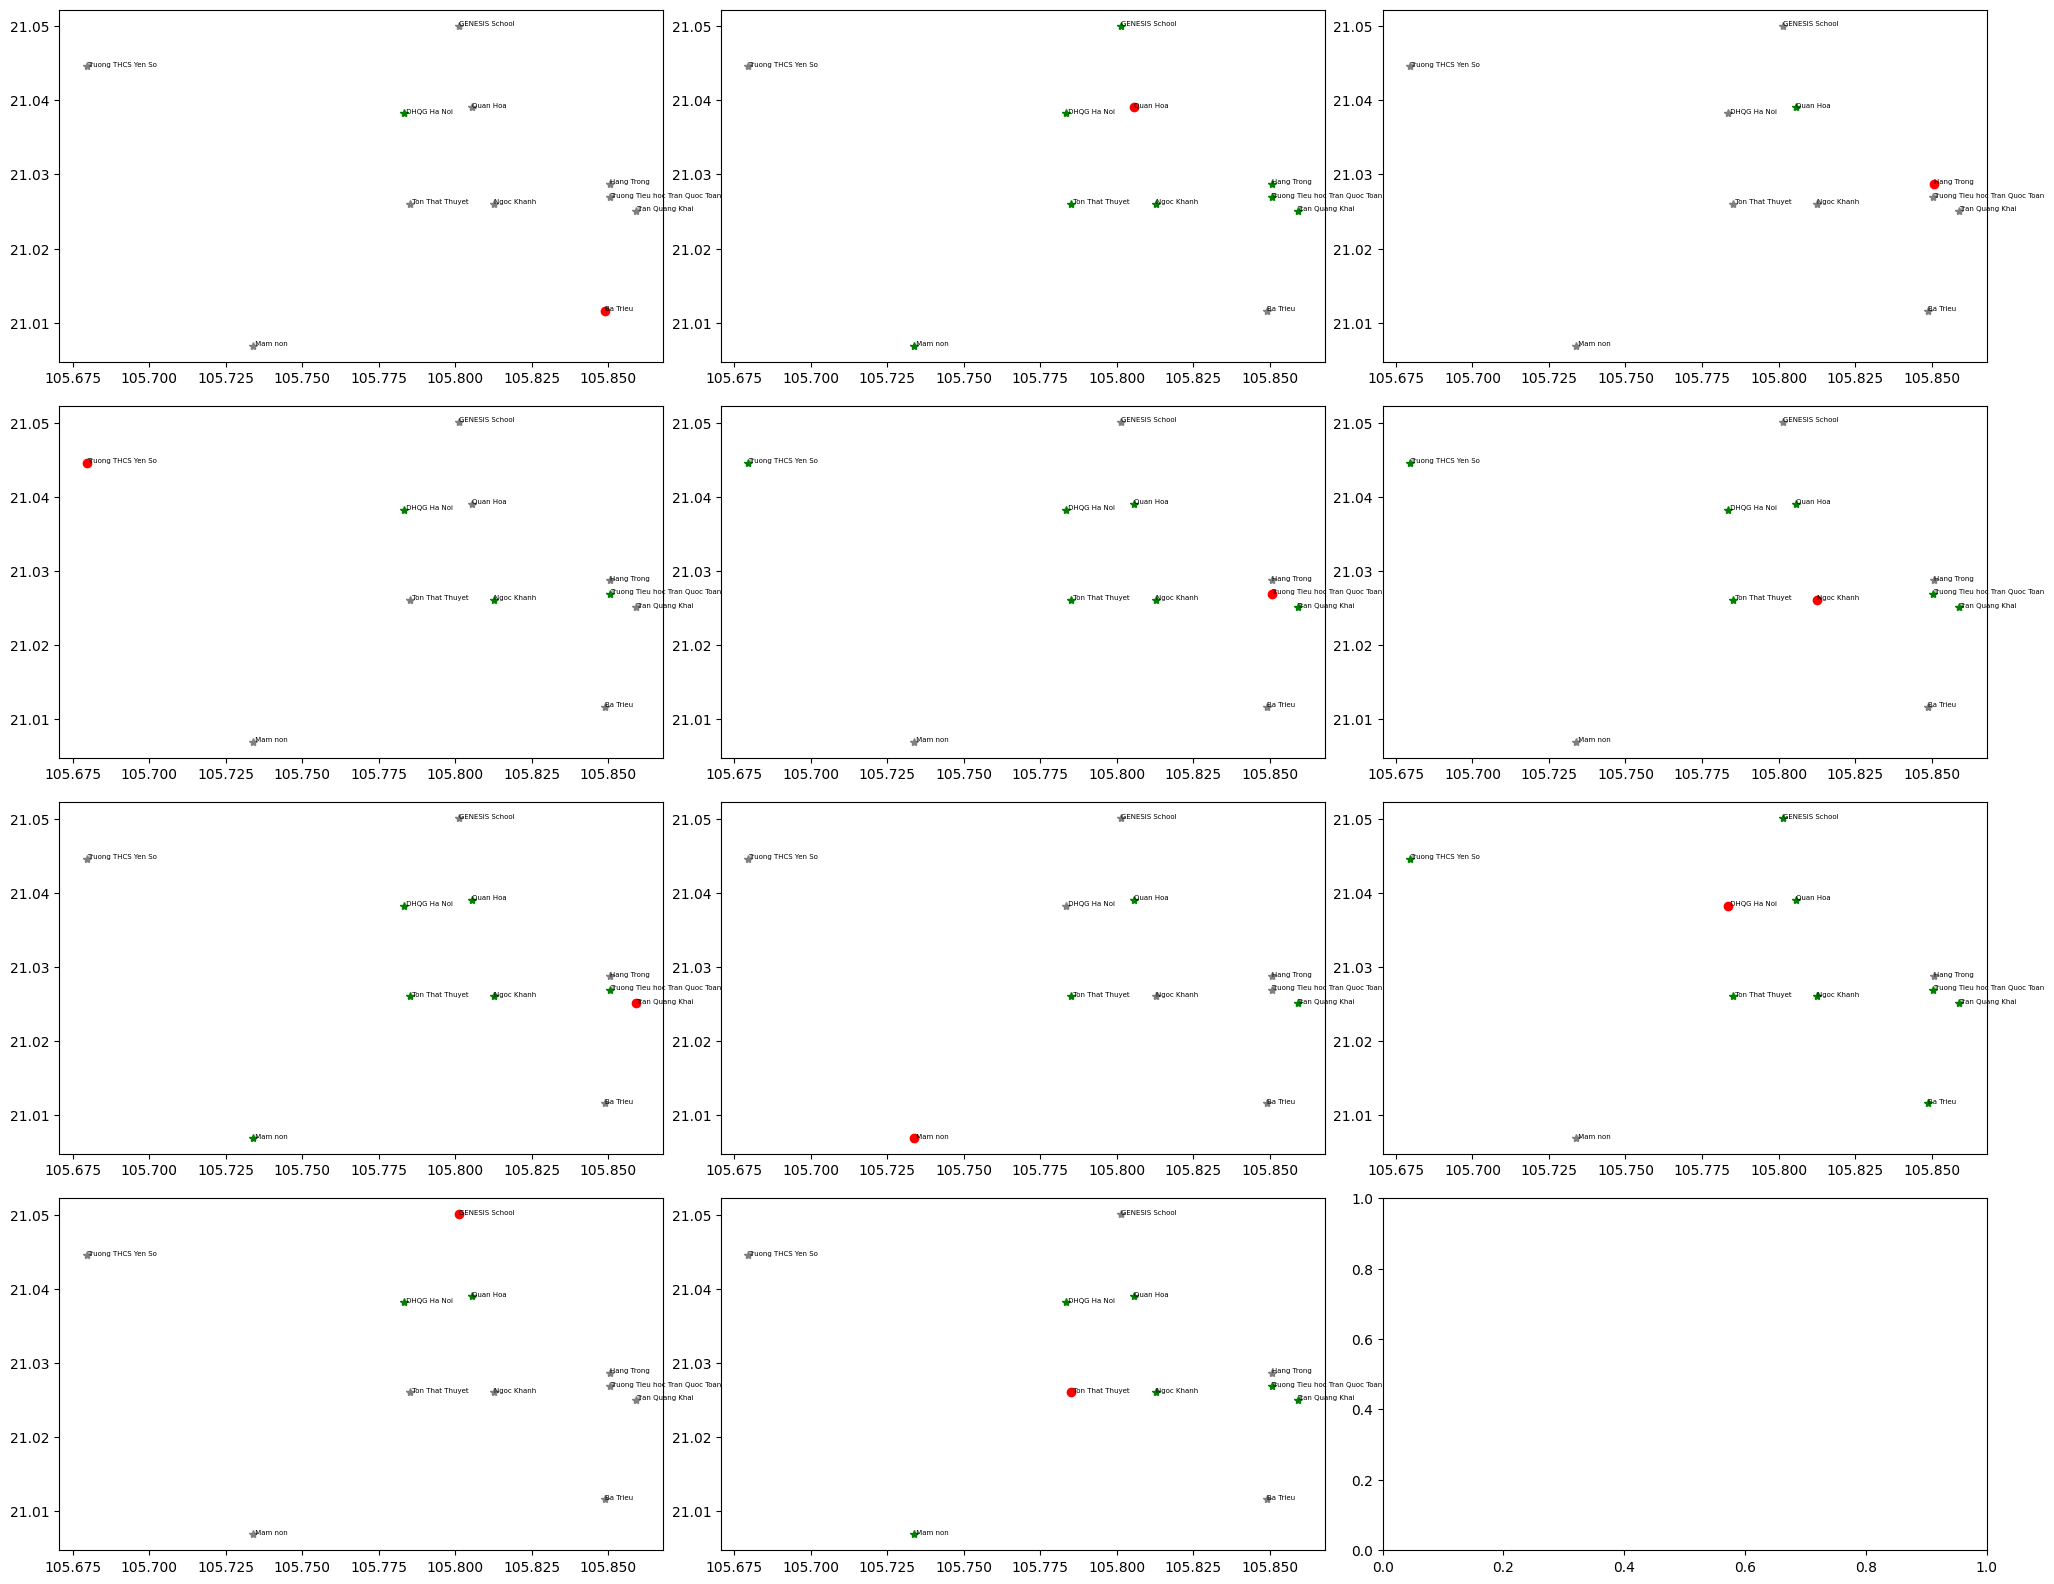

In [9]:
plot_stations_corr(raw["input"], corr, threshold=0.85, dpi=100, figsize=(20, 16))

# Data AutoCorrelation

In [10]:
def max_auto_corr(x: pd.Series, lim):
    x = x.interpolate(option="spline")

    corrs = []

    for lag in range(lim[0], lim[1] + 1):
        autocorr = x.autocorr(lag=lag)

        corrs.append(autocorr)

    max_corr = []

    for i in range(1, len(corrs) - 1):
        if corrs[i] > corrs[i - 1] and corrs[i] > corrs[i + 1]:
            max_corr.append(i)

    return torch.tensor(max_corr) + 1

station = raw["input"]["S0000370-Ba Trieu"]["data"]
max_auto_corr(station["PM2.5"], lim=(1, 200)) / 24

tensor([0.9583, 2.0000, 3.0000, 3.5000, 4.0000, 4.5417, 5.0000, 6.0000, 6.5417,
        7.0417, 7.6250, 8.0000])

[]

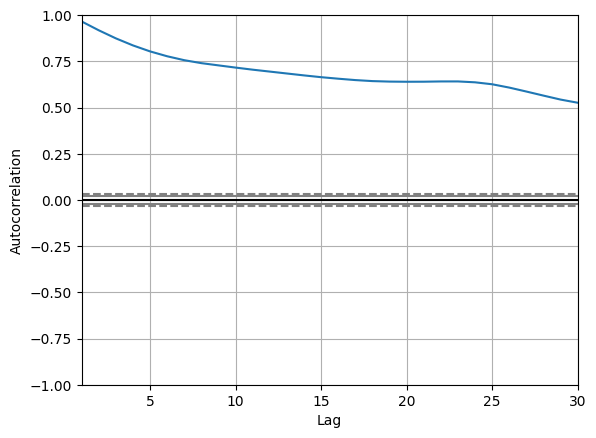

In [11]:
x = pd.plotting.autocorrelation_plot(station["PM2.5"].dropna())
x.set_xlim([1, 30])
x.plot()

# Station's Distribution

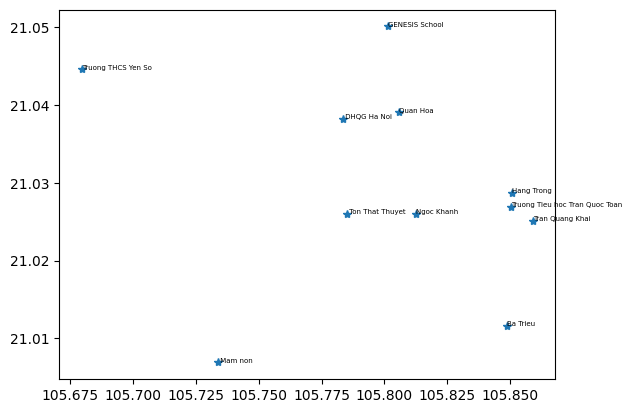

In [12]:
def plot_stations_dist():
    long, lat, names = [], [], []

    for name, station in raw["input"].items():
        long.append(station["loc"][0])
        lat.append(station["loc"][1])
        names.append(name.split("-")[-1])

    plt.plot(long, lat, "*")

    for i in range(len(names)):
        plt.text(long[i], lat[i], names[i], fontsize=5)

    plt.show()

plot_stations_dist()